In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/drive/MyDrive/2022-1/국비지원교육/실습폴더/crawling_on_bare_ground/drama_final.csv")

In [3]:
df.groupby('genre').count()

,Unnamed: 0,review
genre,,
crime,4580,4580
drama,1558,1558
fantasySF,2136,2136
roco,4606,4606
thriller,10069,10069


In [4]:
sf = df[df['genre']=='fantasySF'].review.to_list()
sentence = ",".join(sf)

# 필요 함수들

In [ ]:
# pip install contextualized_topic_models

In [6]:
import re
import pandas as pd
import numpy as np
import string
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
# from contextualized_topic_models.models.ctm import CombinedTM
# from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation, bert_embeddings_from_list
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from konlpy.tag import Okt
from tqdm import tqdm

In [7]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('V'):
        return 'v'
    elif pos_tag.startswith('N'):
        return 'n'
    elif pos_tag.startswith('J'):
        return 'a'
    elif pos_tag.startswith('R'):
        return 'r'
    else:
        return None

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
stop_words.update(('\r', '\n', '\r\n', '\n\r'))

In [9]:
class CustomTokenizer:
    def __init__(self, tagger):
        self.tagger = tagger
    def __call__(self, a):
        a = ''.join(a)
        word_tokens = self.tagger(a)
        
        words = []

        for i in word_tokens:
            text = re.sub('[^a-zA-Z0-9\']','',i).strip()
            text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`…》]','', text)
            if(text != ''):
                words.append(text)
        
        tag_words = nltk.pos_tag(words)
        pos_words = [word for word in tag_words if word[1][0] in {'V','N','J','R'}]
        # pos_words = [word if word[1].startswith('V') else word if word[1].startswith('N') else word if word[1].startswith('J') else word if word[1].startswith('R') else word for word in tag_words]
        temp_list = []
        for token, pos_tag in pos_words:
            tag = get_wordnet_pos(pos_tag)
            if tag != None:
                temp_list.append((token, get_wordnet_pos(pos_tag)))
        lemma = WordNetLemmatizer()
        token_final = [lemma.lemmatize(token, pos=tag) for token, tag in temp_list]
        long_words = [i for i in token_final if len(i) > 2]
        results = [w for w in long_words if w not in stop_words]
        return results

# 작업

In [24]:
ngram_range = (1,3)
stop_words = set(stopwords.words('english'))
stop_words.update(('\r', '\n', '\r\n', '\n\r'))

custom_tokenizer = CustomTokenizer(text_to_word_sequence)
custom_tokenizer(sentence)

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer,ngram_range = ngram_range, stop_words=stop_words,
                        max_df=10, min_df=2).fit(sf)
candidates = tfidf.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [26]:
len(candidates)

22199

# 임베딩

In [27]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
doc_embedding = model.encode([sentence])
candidate_embeddings = model.encode(candidates)

In [ ]:
candidate_embeddings.shape

(24356, 768)

# 코사인 유사도 연구(건너뛰어도 됨)

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

top_n = len(candidates)

# 문서와 키워드간 유사도
distances = cosine_similarity(doc_embedding, candidate_embeddings)

# 키워드와 키워드간 유사도
distances_candidates = cosine_similarity(candidate_embeddings)

In [20]:
distances.shape, distances_candidates.shape, len(keywords) # candidates[index]

((1, 24356), (24356, 24356), 24356)

In [35]:
word_doc_distances = cosine_similarity(candidate_embeddings,doc_embedding)
word_distances = cosine_similarity(candidate_embeddings)

(24356, 24356)

In [74]:
keywords_idx = [5,6,7,8,9]
candidates_idx = [1,2,3,4]
candidate_similarities = word_doc_distances[candidates_idx, :]
candidate_similarities, candidate_similarities.shape # 후보키워드의 문서간유사도 벡터

(array([[-0.07816583],
        [ 0.13329102],
        [ 0.4734827 ],
        [-0.01397669]], dtype=float32), (4, 1))

In [75]:
word_distances[candidates_idx][:,keywords_idx] # 후보키워드와 추출키워드의 유사도 벡터

array([[ 0.30213898,  0.23212501,  0.10909769,  0.05130924,  0.2902788 ],
       [ 0.0680101 , -0.04748184,  0.00118963, -0.11905266,  0.04692692],
       [ 0.0434835 ,  0.03092792,  0.12414388,  0.19775468,  0.27358925],
       [ 0.21618617,  0.07923687,  0.12128276,  0.04189737,  0.1612878 ]],
      dtype=float32)

In [70]:
 target_similarities = np.max(word_distances[candidates_idx][:,keywords_idx], axis=1)
 target_similarities, target_similarities.shape # 후보키워드와 가장 유사한 추출 키워드 벡터

(array([0.30213898, 0.0680101 , 0.21618617], dtype=float32), (3,))

In [73]:
mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1,1)
mmr,mmr.shape # mmr 계산을 통해 후보키워드에서 추출할 키워드 선정

(array([[-0.23494704],
        [-0.00761976],
        [-0.15552332]], dtype=float32), (3, 1))

# 코사인 유사도 함수

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
top_n = 1000
diversity = 0.7

def mmr(doc_embedding, word_embeddings, words, top_n, diversity):
    word_doc_distances = cosine_similarity(candidate_embeddings,doc_embedding)
    word_distances = cosine_similarity(candidate_embeddings) 

    keywords_idx = [np.argmax(word_doc_distances)]
    candidates_idx = [i for i in range(len(candidates)) if i != keywords_idx[0]]

    for _ in range(top_n-1):
        candidate_similarities = word_doc_distances[candidates_idx, :] # 후보 키워드들의 문서유사도 값
        target_similarities = np.max(word_distances[candidates_idx][:,keywords_idx], axis=1) # 후보 키워드와 가장 유사한 키워드

        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1,1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)
    
    keywords_vector = word_embeddings[keywords_idx][:] # 본 단어 임베딩벡터에서 추출키워드에 해당하는 벡터만
    keywords = [words[idx] for idx in keywords_idx]
    
    return keywords_vector, keywords


In [29]:
keywords_vector, keywords = mmr(doc_embedding,candidate_embeddings,candidates,top_n=500,diversity=0.6)

In [43]:
keywords_vector.shape

(500, 768)

In [66]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

X = keywords_vector

true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X.T)



KMeans(max_iter=100, n_clusters=6, n_init=1)

In [67]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = keywords # = candidates
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s,' % terms[ind],end = '')
    print("\n")


Top terms per cluster:
Cluster 0:
 countless computer screen, excitement never stop, hdl extremely hype, watch scary, can't stop watching, big fan sci, overdone, live thousand, thing worry everyone, many hollywood,

Cluster 1:
 fake overact rest, dreamy series fill, really enjoy plot, production fantasy, suspense thriller factor, act impulsive wear, exceptional really wish, lot time dedicate, surprise acting, plot distract people,

Cluster 2:
 love fashion, chemistry fell love, battle together bound, kim's long favorite, world koo's training, performance also spot, chefs kiss, jump protect friend, train busan, chain tree tie,

Cluster 3:
 regular slub can't, lot blood, global drought, become desert, thing worry everyone, problem pacing, post apocalyptic, arc also postpone, team fight many, always skip,

Cluster 4:
 luna walk, train busan, school build pond, nurse fight jelly, global drought, marathon, sacrificial lamb, tea however, injured man walk, chicken,

Cluster 5:
 lazy korea, fi

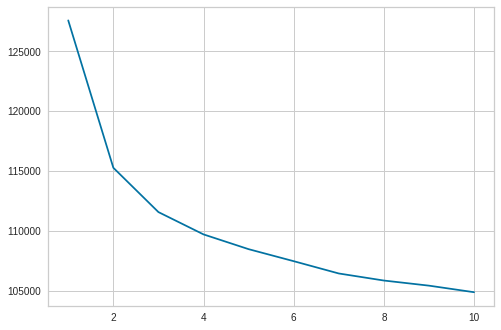

In [69]:
x = list(range(1,11))
y = []
for i in x:
    model = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1)
    model.fit(X.T)
    y.append(model.inertia_)

import matplotlib.pyplot as plt

plt.plot(x,y,label='linear')
plt.show();